## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [13]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [12]:
# # (re-)load layers
# %run modules.ipynb
import torch
import numpy as np
import unittest
from modules import (
    Module, Sequential, Linear, SoftMax, LogSoftMax, BatchNormalization, ChannelwiseScaling,
    Dropout, ReLU, LeakyReLU, ELU, SoftPlus, ClassNLLCriterion, ClassNLLCriterionUnstable,
    Conv2d, MaxPool2d, Flatten, Criterion, sgd_momentum, adam_optimizer
)

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

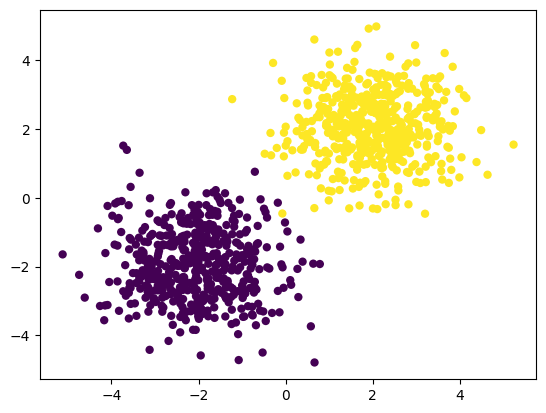

In [14]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [15]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [16]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [17]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

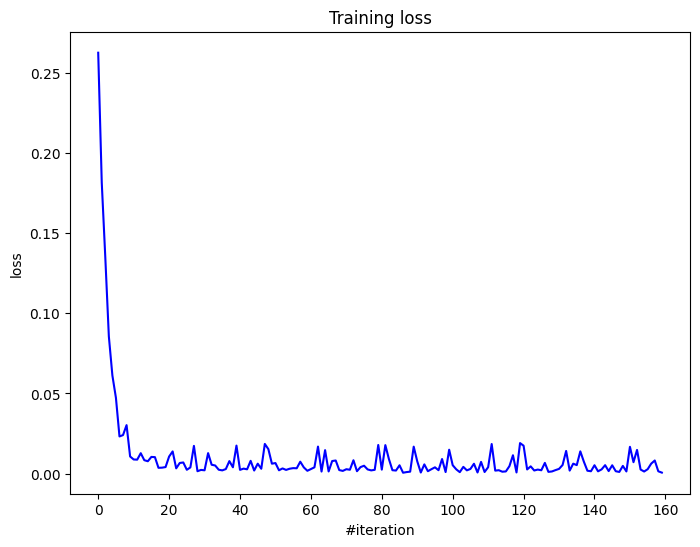

Current loss: 0.000569


In [18]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [ ]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/hw08_nn_from_scratch/mnist.py -nc

In [ ]:
import gzip
import os
import numpy as np

def load_mnist_images(filename):
    if not os.path.exists(filename):
        raise FileNotFoundError(f"{filename} not found.")
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, 1, 28, 28)
    return (data / np.float32(256)).squeeze()

def load_mnist_labels(filename):
    if not os.path.exists(filename):
        raise FileNotFoundError(f"{filename} not found.")
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

# Загрузка данных
X_train = load_mnist_images(r'train-images-idx3-ubyte.gz')
y_train = load_mnist_labels(r'train-labels-idx1-ubyte.gz')
X_test = load_mnist_images(r't10k-images-idx3-ubyte.gz')
y_test = load_mnist_labels(r't10k-labels-idx1-ubyte.gz')

# Разделение тренировочных данных на тренировочные и валидационные
X_train, X_val = X_train[:-10000], X_train[-10000:]
y_train, y_val = y_train[:-10000], y_train[-10000:]

# Определение flatten
flatten = True  # Установите в False, если хотите оставить данные в 4D

# Преобразование данных, если flatten=True
if flatten:
    X_train = X_train.reshape([-1, 28**2])
    X_val = X_val.reshape([-1, 28**2])
    X_test = X_test.reshape([-1, 28**2])

# Вывод форм массивов
print("Форма X_train:", X_train.shape)
print("Форма y_train:", y_train.shape)
print("Форма X_val:", X_val.shape)
print("Форма y_val:", y_val.shape)
print("Форма X_test:", X_test.shape)
print("Форма y_test:", y_test.shape)


Форма X_train: (50000, 784)
Форма y_train: (50000,)
Форма X_val: (10000, 784)
Форма y_val: (10000,)
Форма X_test: (10000, 784)
Форма y_test: (10000,)


One-hot encode the labels first.

In [20]:
# Your code goes here. ################################################
def one_hot_labels(y):
    y_oh = np.zeros((len(y), 10))
    y_oh[np.arange(len(y)), y] = 1
    return y_oh

y_train = one_hot_labels(y_train)
y_val = one_hot_labels(y_val)
y_test = one_hot_labels(y_test)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [21]:
# Your code goes here. ################################################

def train(net, optimizer_config, optimizer_state, batch_size=128, n_epoch=20, title=None, opt='sgd'):
    loss_history_train = []
    loss_history_val = []
    loss_history_test = []
    acc_history_train = []
    acc_history_val = []
    acc_history_test = []
    
    train_loss_epoch = []
    train_acc_epoch = []

    for i in range(n_epoch):
        loss_epoch = []
        acc_epoch = []
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):

            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            if opt == 'sgd':
                optimizer = sgd_momentum
            elif opt == 'adam':
                optimizer = adam_optimizer
            else:
                print('Try SGD or Adam')
            optimizer(net.getParameters(),
                      net.getGradParameters(), 
                      optimizer_config,
                      optimizer_state)      

            acc = (np.where(y_batch)[1] == predictions.argmax(axis=1)).mean()
            
            loss_epoch.append(loss)
            acc_epoch.append(acc)
            
            loss_history_train.append(loss)
            acc_history_train.append(acc)
        
        train_loss_epoch.append(np.array(loss_epoch).mean())
        train_acc_epoch.append(np.array(acc_epoch).mean())
        
        steps_train = len(X_train) / batch_size

        loss_val = 0
        correct_val = 0
        for x_batch, y_batch in get_batches((X_val, y_val), batch_size):
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            correct = (np.where(y_batch)[1] == predictions.argmax(axis=1)).sum()
            
            loss_val += loss
            correct_val += correct
        
        loss_history_val.append((steps_train * (i + 1), loss_val / (len(X_val) / batch_size)))
        acc_history_val.append((steps_train * (i + 1), correct_val / len(X_val)))
        
        loss_test = 0
        correct_test = 0
        for x_batch, y_batch in get_batches((X_test, y_test), batch_size):
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            correct = (np.where(y_batch)[1] == predictions.argmax(axis=1)).sum()
            
            loss_test += loss
            correct_test += correct
        
        loss_history_test.append((steps_train * (i + 1), loss_test / (len(X_test) / batch_size)))
        acc_history_test.append((steps_train * (i + 1), correct_test / len(X_test)))

        points_val_loss = np.array(loss_history_val)
        points_test_loss = np.array(loss_history_test)
        
        # Visualize
        
        # loss
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))
        
        if title:
            plt.title("Loss history: " + title)
        else:
            plt.title('Loss history')
        plt.xlabel("iteration")
        plt.ylabel("loss")
        plt.plot(loss_history_train, label='train', zorder=1)
        plt.scatter(points_val_loss[:, 0], points_val_loss[:, 1], color='orange', marker='+', s=250, label='validation', zorder=2)
        plt.scatter(points_test_loss[:, 0], points_test_loss[:, 1], color='red', marker='x', s=250, label='test', zorder=2)
        plt.legend(loc='best')
        plt.show()

        # accuracy
        plt.figure(figsize=(8, 6))
        
        points_val_acc = np.array(acc_history_val)
        points_test_acc = np.array(acc_history_test)
        
        if title:
            plt.title("Accuracy history: " + title)
        else:
            plt.title("Accuracy history")
        plt.xlabel("iteration")
        plt.ylabel("accuracy")
        plt.plot(acc_history_train, label='train', zorder=1)
        plt.scatter(points_val_acc[:, 0], points_val_acc[:, 1], color='orange', marker='+', s=250, label='validation', zorder=2)
        plt.scatter(points_test_acc[:, 0], points_test_acc[:, 1], color='red', marker='x', s=250, label='test', zorder=2)
        plt.legend(loc='best')
        plt.show()
    
    print('Validation accuracy: %f' % acc_history_val[-1][1])
    print('Test accuracy: %f' % acc_history_test[-1][1])
    
    return train_loss_epoch, train_acc_epoch, points_val_loss[:, 1], points_val_acc[:, 1], points_test_loss[:, 1], points_test_acc[:, 1]

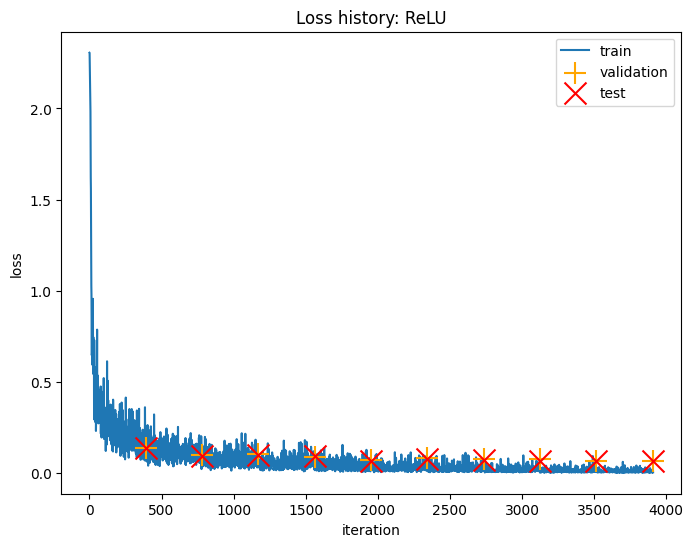

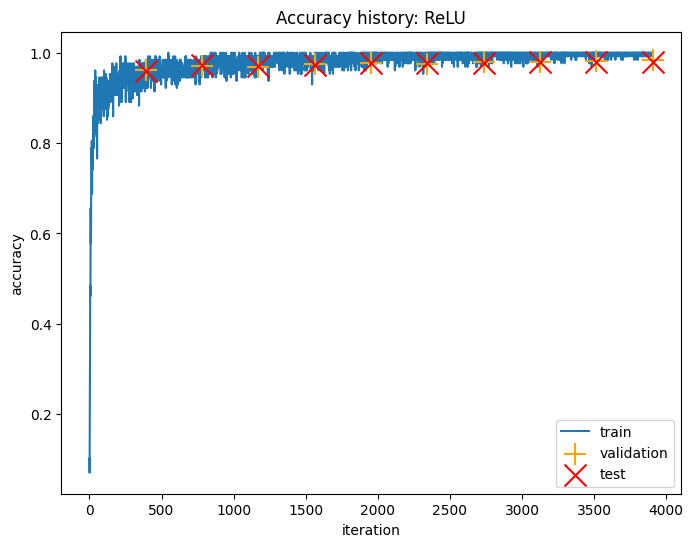

Validation accuracy: 0.982800
Test accuracy: 0.979800
CPU times: total: 2min 43s
Wall time: 32.4 s


In [22]:
%%time

net = Sequential()
net.add(Flatten())
net.add(Linear(784, 256))
net.add(ReLU())
net.add(Linear(256, 10))
net.add(LogSoftMax())

# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

train_loss_relu, train_acc_relu, val_loss_relu, val_acc_relu, test_loss_relu, test_acc_relu =\
                    train(net, optimizer_config, optimizer_state, n_epoch=10, title='ReLU')

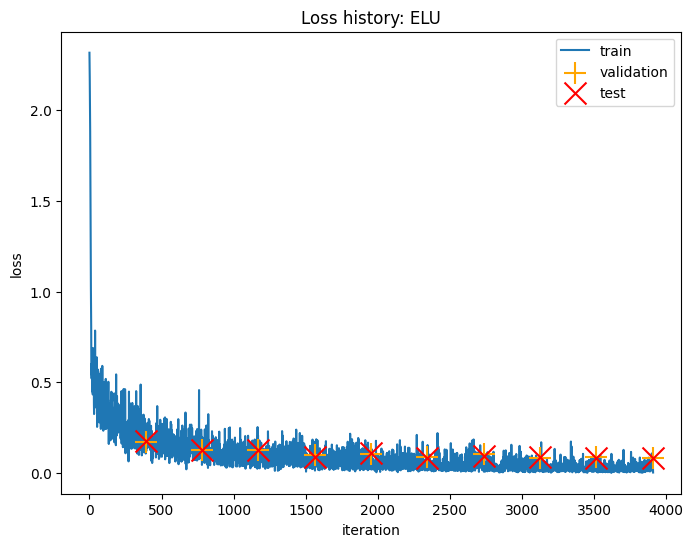

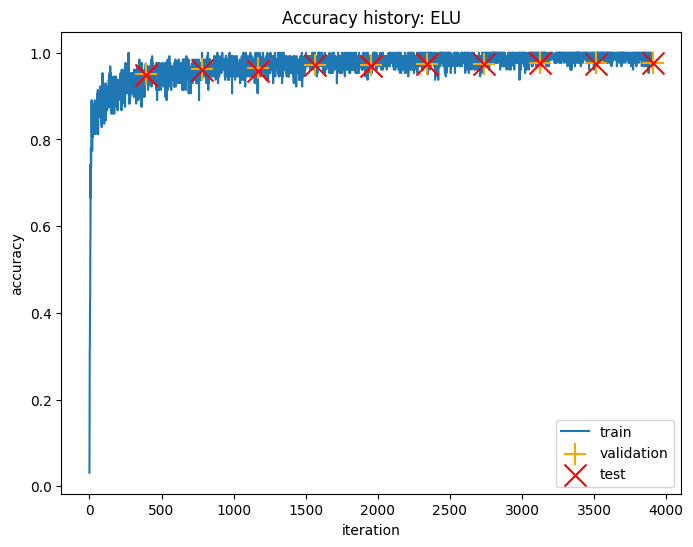

Validation accuracy: 0.976900
Test accuracy: 0.975800
CPU times: total: 3min 16s
Wall time: 46.5 s


In [23]:
%%time

net = Sequential()
net.add(Flatten())
net.add(Linear(784, 256))
net.add(ELU())
net.add(Linear(256, 10))
net.add(LogSoftMax())

# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

train_loss_elu, train_acc_elu, val_loss_elu, val_acc_elu, test_loss_elu, test_acc_elu =\
                    train(net, optimizer_config, optimizer_state, n_epoch=10, title='ELU')

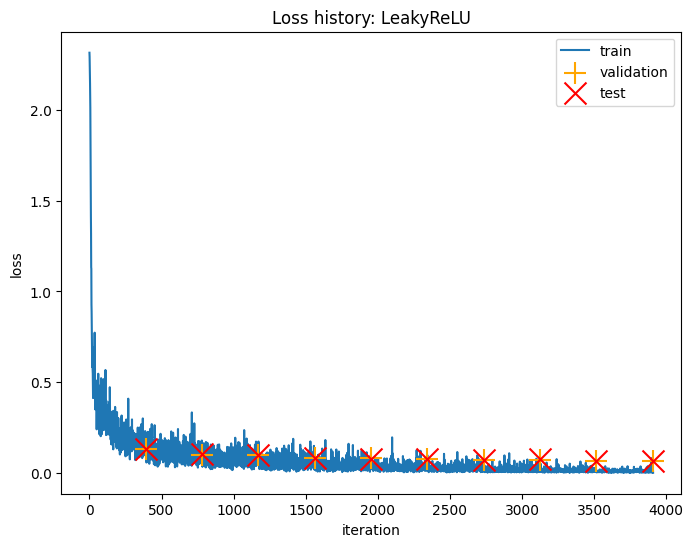

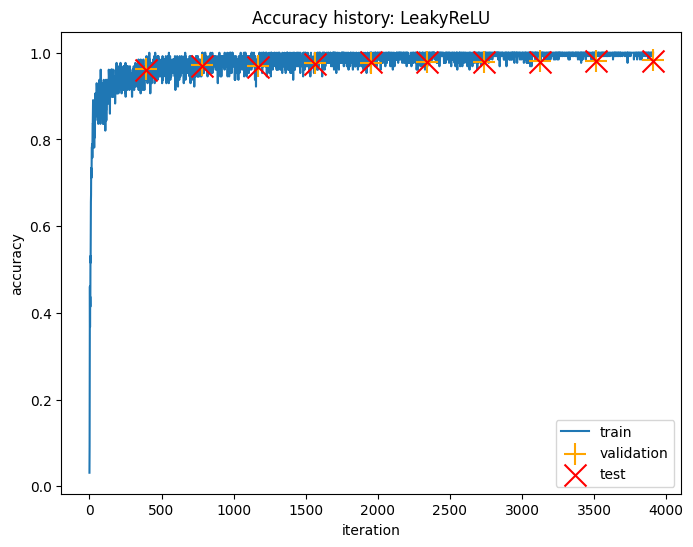

Validation accuracy: 0.982500
Test accuracy: 0.981400
CPU times: total: 3min 2s
Wall time: 38.4 s


In [24]:
%%time

net = Sequential()
net.add(Flatten())
net.add(Linear(784, 256))
net.add(LeakyReLU())
net.add(Linear(256, 10))
net.add(LogSoftMax())

# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

train_loss_leakyrelu, train_acc_leakyrelu, val_loss_leakyrelu, val_acc_leakyrelu, test_loss_leakyrelu, test_acc_leakyrelu =\
                    train(net, optimizer_config, optimizer_state, n_epoch=10, title='LeakyReLU')

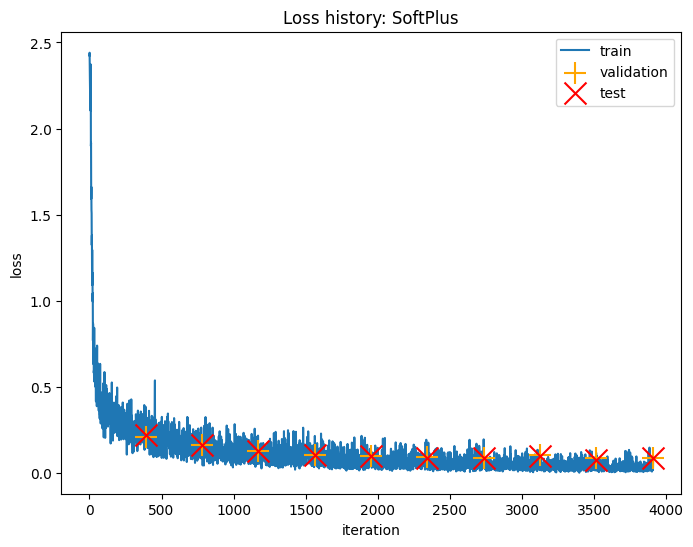

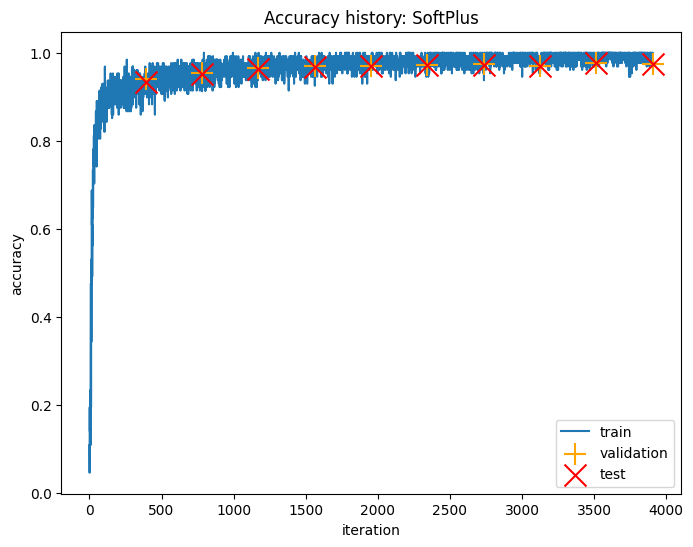

Validation accuracy: 0.975500
Test accuracy: 0.975300
CPU times: total: 3min 24s
Wall time: 48.5 s


In [25]:
%%time

net = Sequential()
net.add(Flatten())
net.add(Linear(784, 256))
net.add(SoftPlus())
net.add(Linear(256, 10))
net.add(LogSoftMax())

# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

train_loss_softplus, train_acc_softplus, val_loss_softplus, val_acc_softplus, test_loss_softplus, test_acc_softplus =\
                    train(net, optimizer_config, optimizer_state, n_epoch=10, title='SoftPlus')

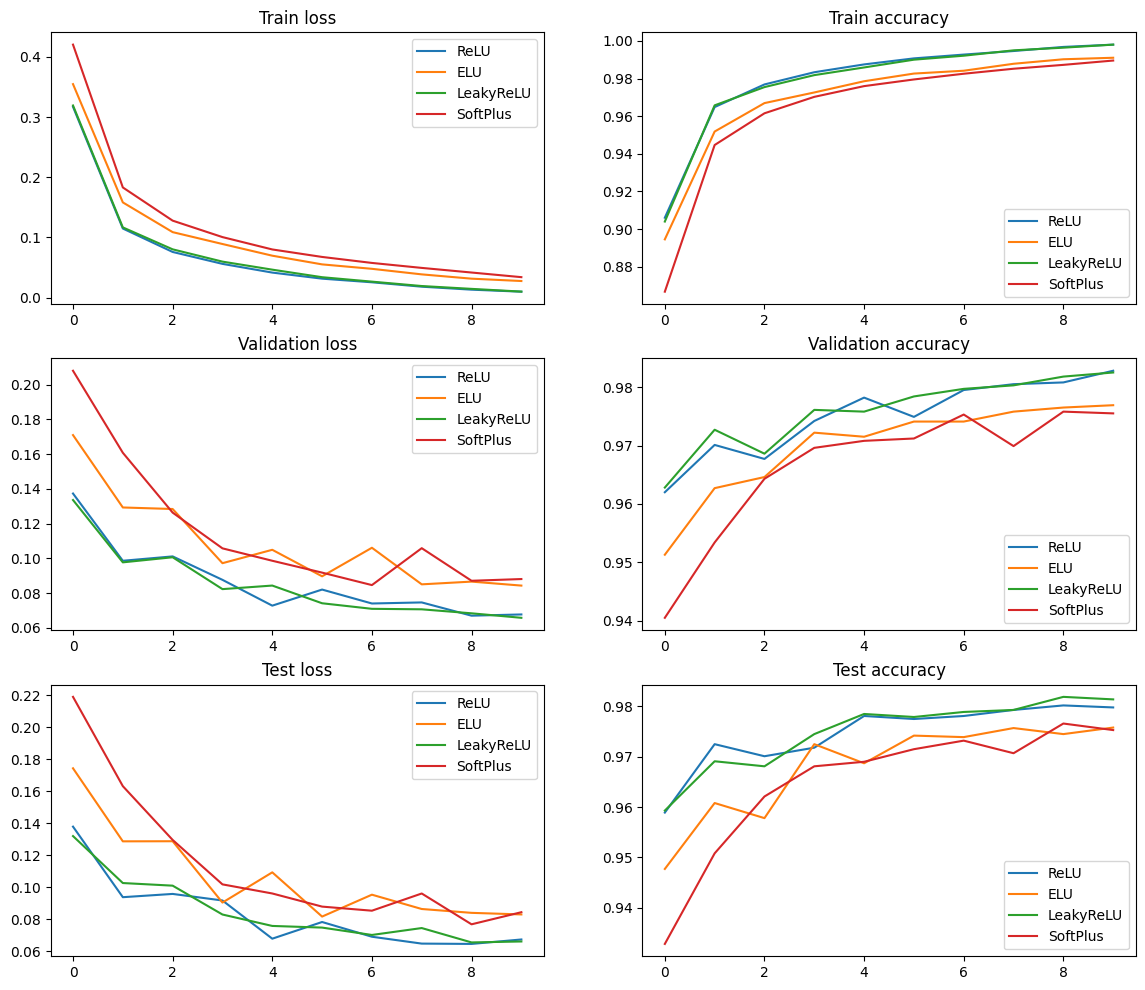

In [26]:
f, axes = plt.subplots(3, 2, figsize=(14, 12))

axes[0, 0].set_title('Train loss')
axes[0, 0].plot(train_loss_relu, label='ReLU')
axes[0, 0].plot(train_loss_elu, label='ELU')
axes[0, 0].plot(train_loss_leakyrelu, label='LeakyReLU')
axes[0, 0].plot(train_loss_softplus, label='SoftPlus')
axes[0, 0].legend(loc='best')

axes[1, 0].set_title('Validation loss')
axes[1, 0].plot(val_loss_relu, label='ReLU')
axes[1, 0].plot(val_loss_elu, label='ELU')
axes[1, 0].plot(val_loss_leakyrelu, label='LeakyReLU')
axes[1, 0].plot(val_loss_softplus, label='SoftPlus')
axes[1, 0].legend(loc='best')

axes[2, 0].set_title('Test loss')
axes[2, 0].plot(test_loss_relu, label='ReLU')
axes[2, 0].plot(test_loss_elu, label='ELU')
axes[2, 0].plot(test_loss_leakyrelu, label='LeakyReLU')
axes[2, 0].plot(test_loss_softplus, label='SoftPlus')
axes[2, 0].legend(loc='best')

axes[0, 1].set_title('Train accuracy')
axes[0, 1].plot(train_acc_relu, label='ReLU')
axes[0, 1].plot(train_acc_elu, label='ELU')
axes[0, 1].plot(train_acc_leakyrelu, label='LeakyReLU')
axes[0, 1].plot(train_acc_softplus, label='SoftPlus')
axes[0, 1].legend(loc='best')

axes[1, 1].set_title('Validation accuracy')
axes[1, 1].plot(val_acc_relu, label='ReLU')
axes[1, 1].plot(val_acc_elu, label='ELU')
axes[1, 1].plot(val_acc_leakyrelu, label='LeakyReLU')
axes[1, 1].plot(val_acc_softplus, label='SoftPlus')
axes[1, 1].legend(loc='best')

axes[2, 1].set_title('Test accuracy')
axes[2, 1].plot(test_acc_relu, label='ReLU')
axes[2, 1].plot(test_acc_elu, label='ELU')
axes[2, 1].plot(test_acc_leakyrelu, label='LeakyReLU')
axes[2, 1].plot(test_acc_softplus, label='SoftPlus')
axes[2, 1].legend(loc='best')

plt.show()

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

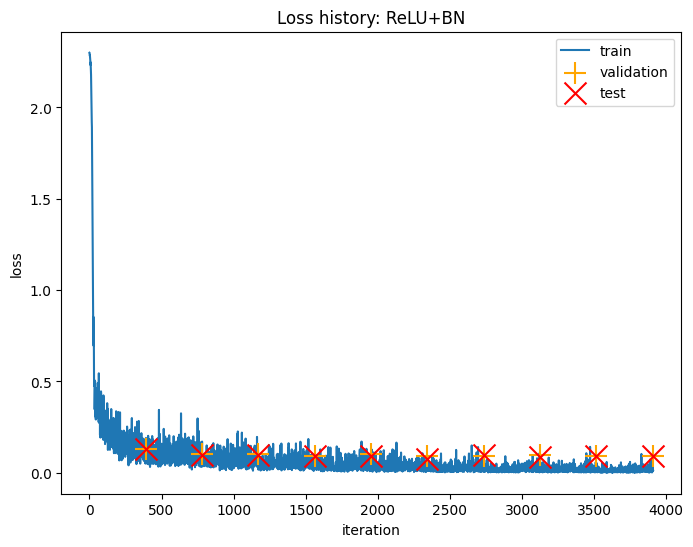

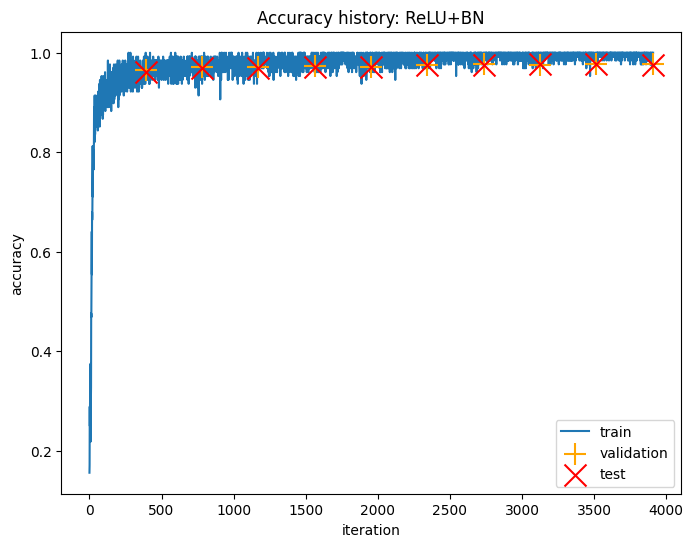

Validation accuracy: 0.976400
Test accuracy: 0.975300


In [ ]:
# Your answer goes here. ################################################


net = Sequential()
net.add(Flatten())
net.add(Linear(784, 256))
net.add(ReLU())
net.add(BatchNormalization(0.01))
net.add(ChannelwiseScaling(256))
net.add(Linear(256, 10))
net.add(LogSoftMax())

# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

train_loss_relu_bn, train_acc_relu_bn, val_loss_relu_bn, val_acc_relu_bn, test_loss_relu_bn, test_acc_relu_bn =\
                    train(net, optimizer_config, optimizer_state, n_epoch=10, title='ReLU+BN')

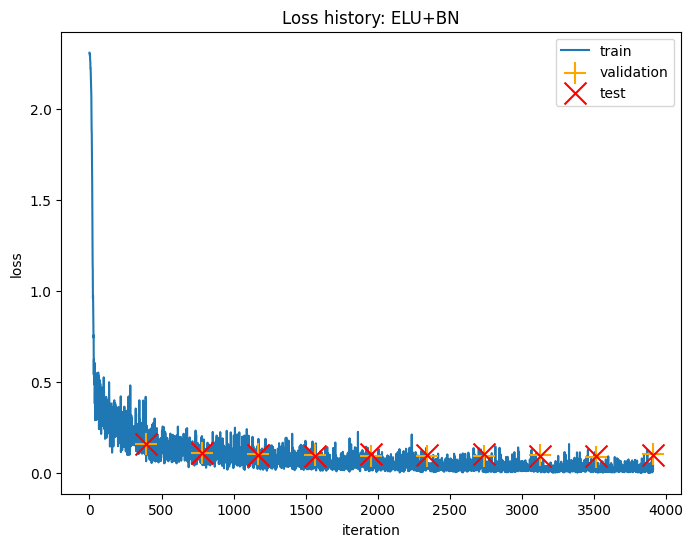

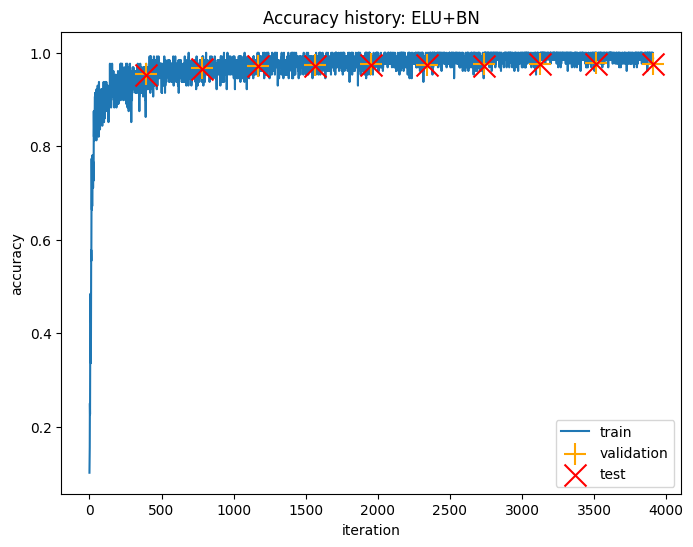

Validation accuracy: 0.975500
Test accuracy: 0.976600
CPU times: total: 2min 46s
Wall time: 44.1 s


In [31]:
%%time

net = Sequential()
net.add(Flatten())
net.add(Linear(784, 256))
net.add(ELU())
net.add(BatchNormalization(0.01))
net.add(ChannelwiseScaling(256))
net.add(Linear(256, 10))
net.add(LogSoftMax())

# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

train_loss_elu_bn, train_acc_elu_bn, val_loss_elu_bn, val_acc_elu_bn, test_loss_elu_bn, test_acc_elu_bn =\
                    train(net, optimizer_config, optimizer_state, n_epoch=10, title='ELU+BN')

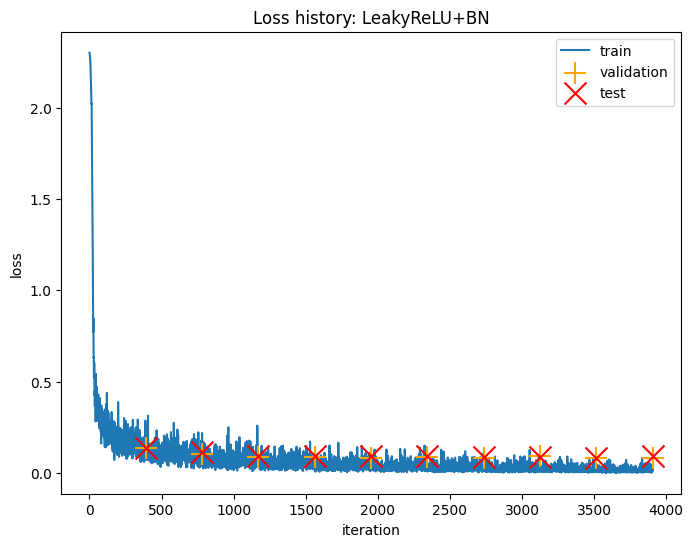

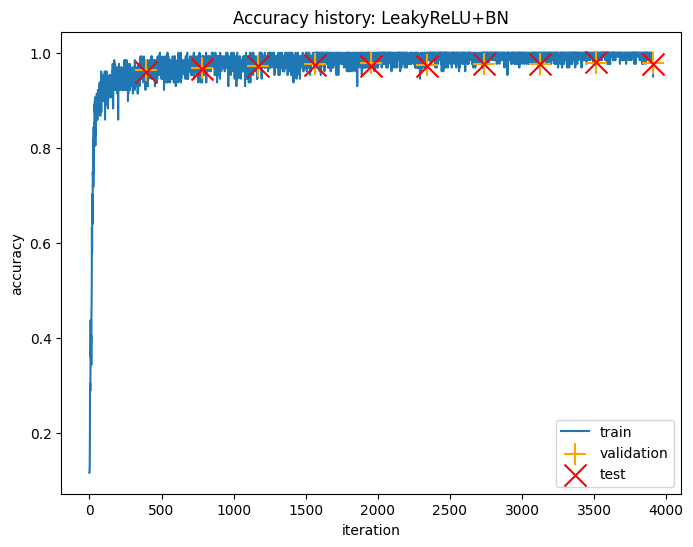

Validation accuracy: 0.977900
Test accuracy: 0.975500
CPU times: total: 2min 52s
Wall time: 43.5 s


In [32]:
%%time

net = Sequential()
net.add(Flatten())
net.add(Linear(784, 256))
net.add(LeakyReLU())
net.add(BatchNormalization(0.01))
net.add(ChannelwiseScaling(256))
net.add(Linear(256, 10))
net.add(LogSoftMax())

# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

train_loss_leakyrelu_bn, train_acc_leakyrelu_bn, val_loss_leakyrelu_bn, val_acc_leakyrelu_bn, test_loss_leakyrelu_bn, test_acc_leakyrelu_bn =\
                    train(net, optimizer_config, optimizer_state, n_epoch=10, title='LeakyReLU+BN')

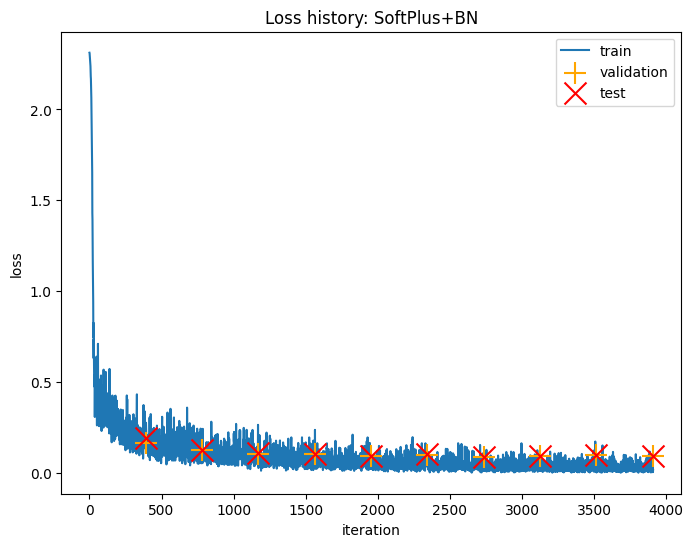

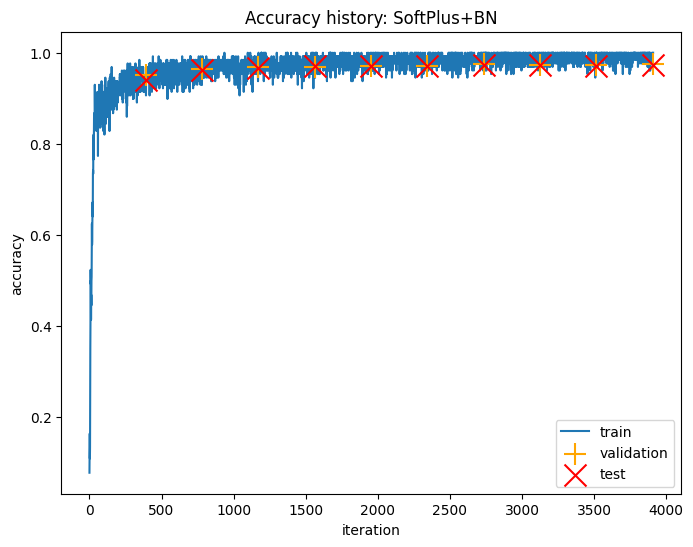

Validation accuracy: 0.974400
Test accuracy: 0.974000
CPU times: total: 2min 57s
Wall time: 45.7 s


In [33]:
%%time

net = Sequential()
net.add(Flatten())
net.add(Linear(784, 256))
net.add(SoftPlus())
net.add(BatchNormalization(0.01))
net.add(ChannelwiseScaling(256))
net.add(Linear(256, 10))
net.add(LogSoftMax())

# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

train_loss_softplus_bn, train_acc_softplus_bn, val_loss_softplus_bn, val_acc_softplus_bn, test_loss_softplus_bn, test_acc_softplus_bn =\
                    train(net, optimizer_config, optimizer_state, n_epoch=10, title='SoftPlus+BN')

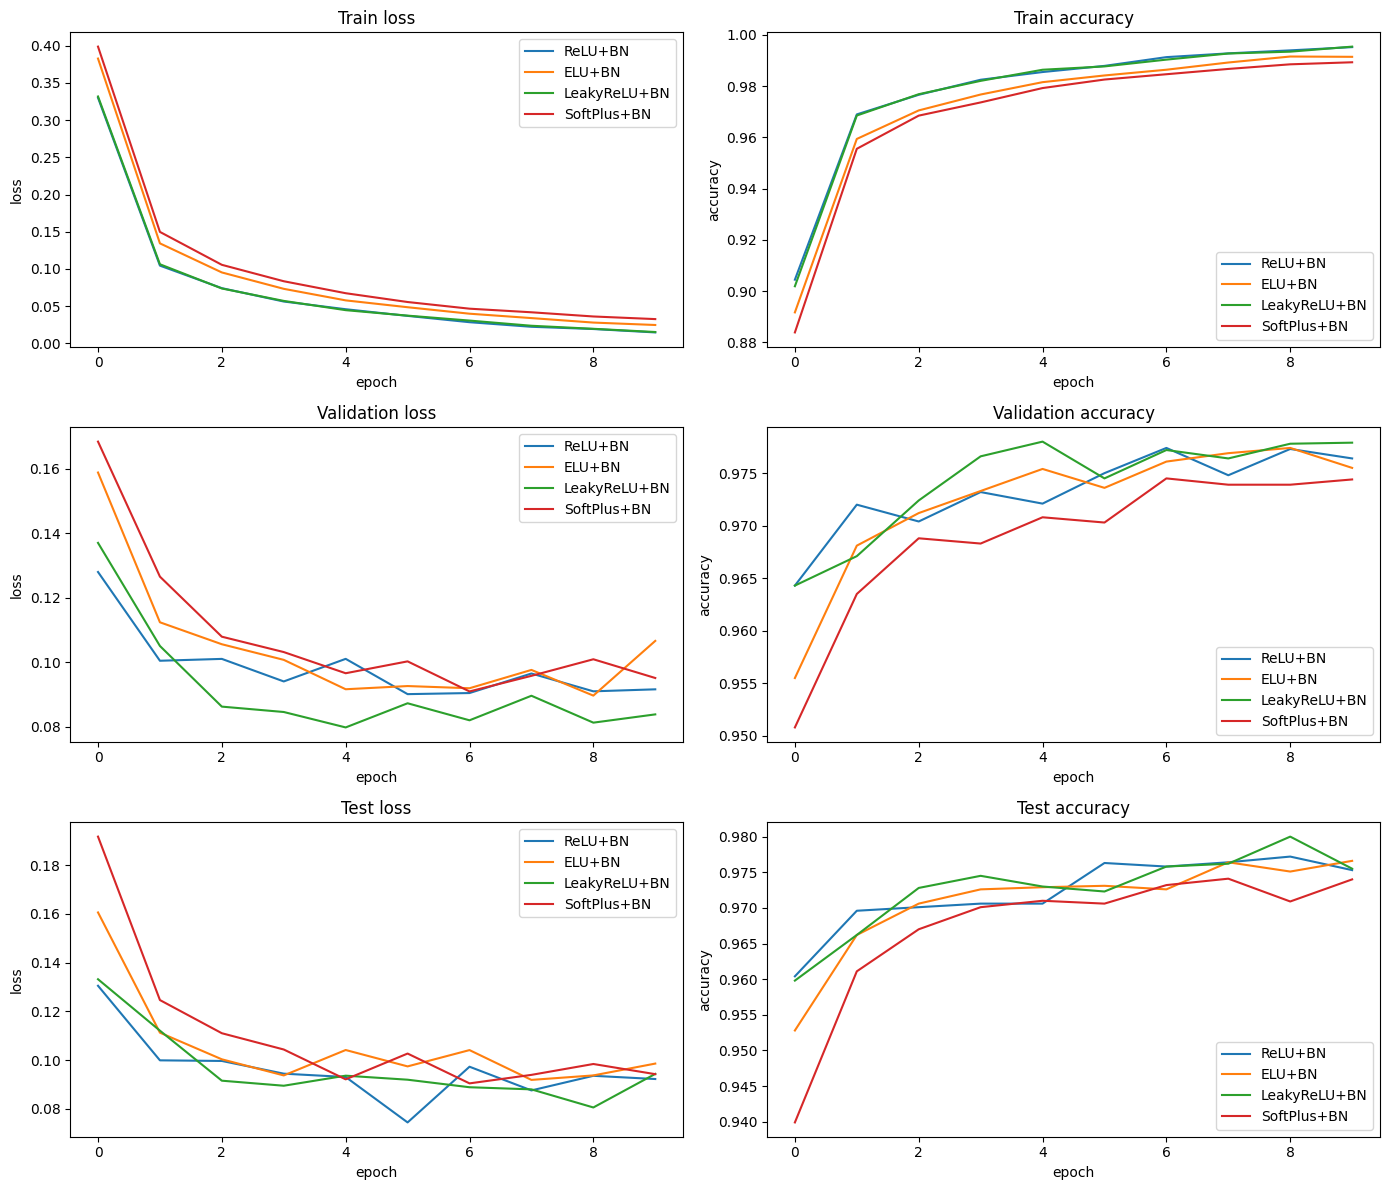

In [34]:
f, axes = plt.subplots(3, 2, figsize=(14, 12))

axes[0, 0].set_title('Train loss')
axes[0, 0].plot(train_loss_relu_bn, label='ReLU+BN')
axes[0, 0].plot(train_loss_elu_bn, label='ELU+BN')
axes[0, 0].plot(train_loss_leakyrelu_bn, label='LeakyReLU+BN')
axes[0, 0].plot(train_loss_softplus_bn, label='SoftPlus+BN')
axes[0, 0].legend(loc='best')
axes[0, 0].set_xlabel('epoch')
axes[0, 0].set_ylabel('loss')

axes[1, 0].set_title('Validation loss')
axes[1, 0].plot(val_loss_relu_bn, label='ReLU+BN')
axes[1, 0].plot(val_loss_elu_bn, label='ELU+BN')
axes[1, 0].plot(val_loss_leakyrelu_bn, label='LeakyReLU+BN')
axes[1, 0].plot(val_loss_softplus_bn, label='SoftPlus+BN')
axes[1, 0].legend(loc='best')
axes[1, 0].set_xlabel('epoch')
axes[1, 0].set_ylabel('loss')

axes[2, 0].set_title('Test loss')
axes[2, 0].plot(test_loss_relu_bn, label='ReLU+BN')
axes[2, 0].plot(test_loss_elu_bn, label='ELU+BN')
axes[2, 0].plot(test_loss_leakyrelu_bn, label='LeakyReLU+BN')
axes[2, 0].plot(test_loss_softplus_bn, label='SoftPlus+BN')
axes[2, 0].legend(loc='best')
axes[2, 0].set_xlabel('epoch')
axes[2, 0].set_ylabel('loss')

axes[0, 1].set_title('Train accuracy')
axes[0, 1].plot(train_acc_relu_bn, label='ReLU+BN')
axes[0, 1].plot(train_acc_elu_bn, label='ELU+BN')
axes[0, 1].plot(train_acc_leakyrelu_bn, label='LeakyReLU+BN')
axes[0, 1].plot(train_acc_softplus_bn, label='SoftPlus+BN')
axes[0, 1].legend(loc='best')
axes[0, 1].set_xlabel('epoch')
axes[0, 1].set_ylabel('accuracy')

axes[1, 1].set_title('Validation accuracy')
axes[1, 1].plot(val_acc_relu_bn, label='ReLU+BN')
axes[1, 1].plot(val_acc_elu_bn, label='ELU+BN')
axes[1, 1].plot(val_acc_leakyrelu_bn, label='LeakyReLU+BN')
axes[1, 1].plot(val_acc_softplus_bn, label='SoftPlus+BN')
axes[1, 1].legend(loc='best')
axes[1, 1].set_xlabel('epoch')
axes[1, 1].set_ylabel('accuracy')

axes[2, 1].set_title('Test accuracy')
axes[2, 1].plot(test_acc_relu_bn, label='ReLU+BN')
axes[2, 1].plot(test_acc_elu_bn, label='ELU+BN')
axes[2, 1].plot(test_acc_leakyrelu_bn, label='LeakyReLU+BN')
axes[2, 1].plot(test_acc_softplus_bn, label='SoftPlus+BN')
axes[2, 1].legend(loc='best')
axes[2, 1].set_xlabel('epoch')
axes[2, 1].set_ylabel('accuracy')

plt.tight_layout()
plt.show()

 Сеть с LeakyReLU работает лучше всего. Однако после добавления BN мы можем увидеть небольшое снижение качества для каждой функции активации, а также времени вычислений.

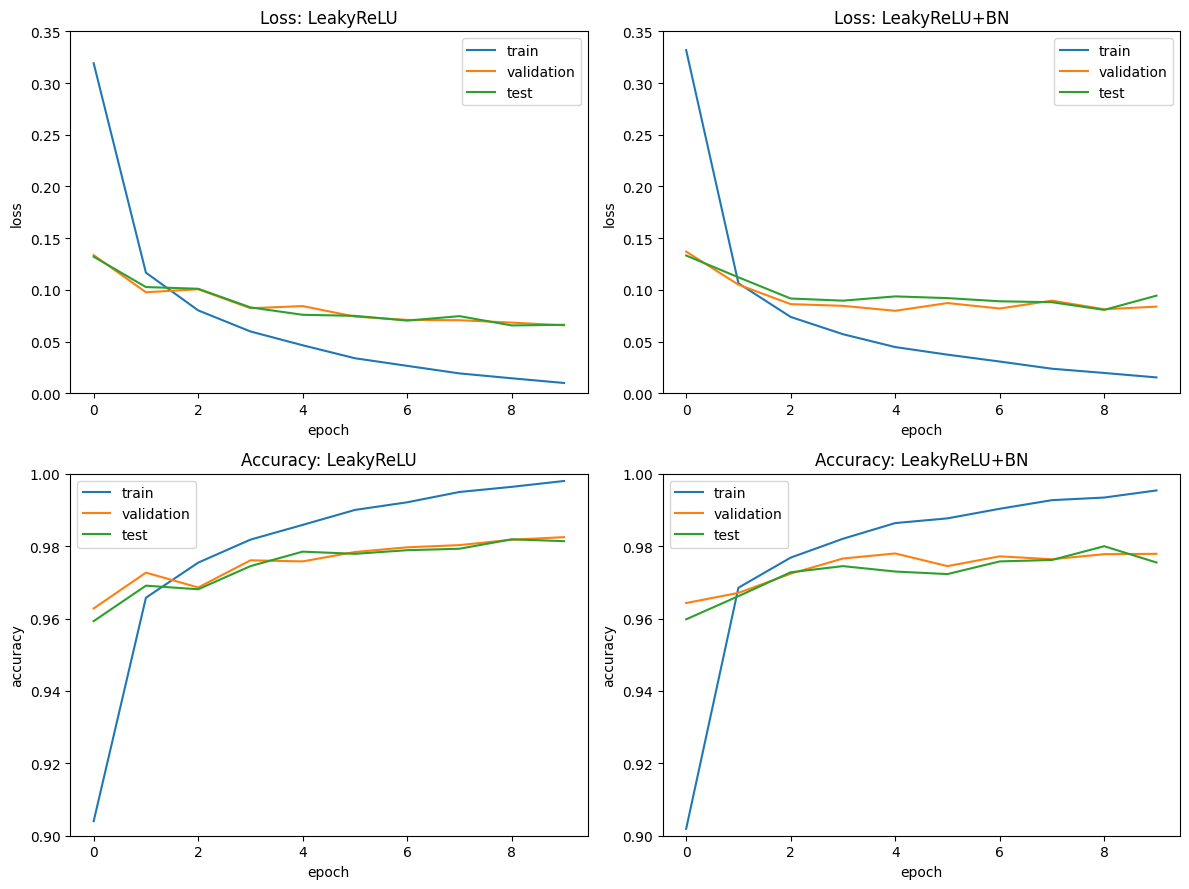

In [35]:
f, axes = plt.subplots(2, 2, figsize=(12, 9))

axes[0, 0].set_title('Loss: LeakyReLU')
axes[0, 0].plot(train_loss_leakyrelu, label='train')
axes[0, 0].plot(val_loss_leakyrelu, label='validation')
axes[0, 0].plot(test_loss_leakyrelu, label='test')
axes[0, 0].legend(loc='best')
axes[0, 0].set_xlabel('epoch')
axes[0, 0].set_ylabel('loss')
axes[0, 0].set_ylim([0, 0.35])

axes[0, 1].set_title('Loss: LeakyReLU+BN')
axes[0, 1].plot(train_loss_leakyrelu_bn, label='train')
axes[0, 1].plot(val_loss_leakyrelu_bn, label='validation')
axes[0, 1].plot(test_loss_leakyrelu_bn, label='test')
axes[0, 1].legend(loc='best')
axes[0, 1].set_xlabel('epoch')
axes[0, 1].set_ylabel('loss')
axes[0, 1].set_ylim([0, 0.35])

axes[1, 0].set_title('Accuracy: LeakyReLU')
axes[1, 0].plot(train_acc_leakyrelu, label='train')
axes[1, 0].plot(val_acc_leakyrelu, label='validation')
axes[1, 0].plot(test_acc_leakyrelu, label='test')
axes[1, 0].legend(loc='best')
axes[1, 0].set_xlabel('epoch')
axes[1, 0].set_ylabel('accuracy')
axes[1, 0].set_ylim([0.9, 1])

axes[1, 1].set_title('Accuracy: LeakyReLU+BN')
axes[1, 1].plot(train_acc_leakyrelu_bn, label='train')
axes[1, 1].plot(val_acc_leakyrelu_bn, label='validation')
axes[1, 1].plot(test_acc_leakyrelu_bn, label='test')
axes[1, 1].legend(loc='best')
axes[1, 1].set_xlabel('epoch')
axes[1, 1].set_ylabel('accuracy')
axes[1, 1].set_ylim([0.9, 1])

plt.tight_layout()
plt.show()

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

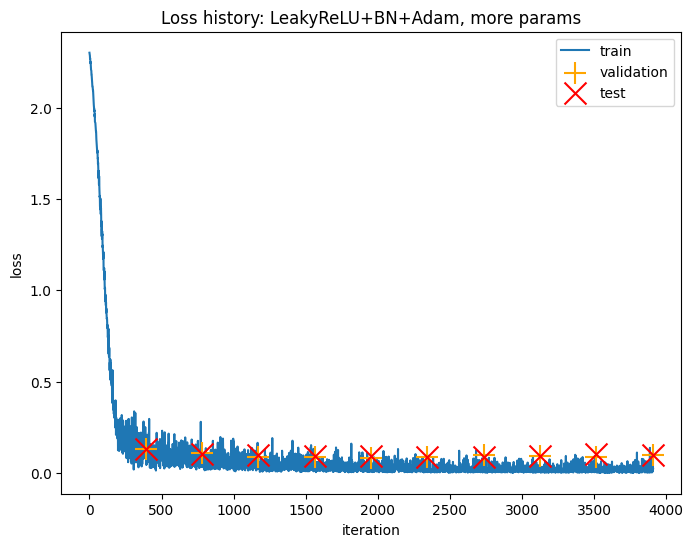

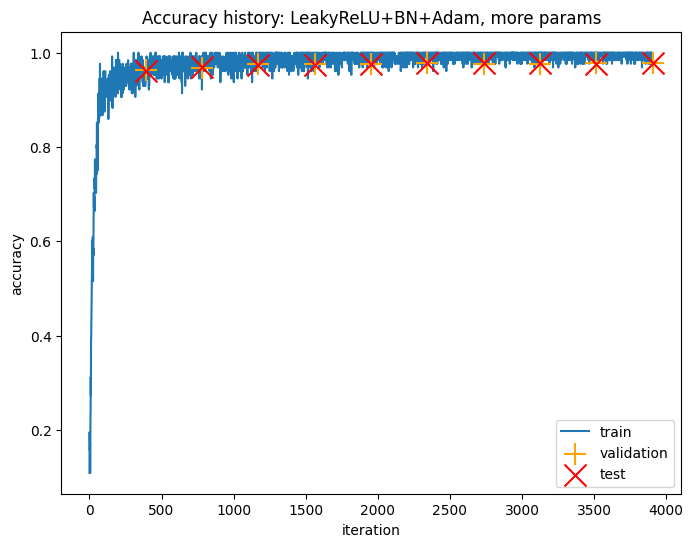

Validation accuracy: 0.977600
Test accuracy: 0.977500
CPU times: total: 8min 24s
Wall time: 2min 16s


In [36]:
%%time

net = Sequential()
net.add(Flatten())
net.add(Linear(784, 512))
net.add(LeakyReLU())
net.add(BatchNormalization(0.01))
net.add(ChannelwiseScaling(512))
net.add(Linear(512, 256))
net.add(LeakyReLU())
net.add(BatchNormalization(0.01))
net.add(ChannelwiseScaling(256))
net.add(Linear(256, 128))
net.add(LeakyReLU())
net.add(BatchNormalization(0.01))
net.add(ChannelwiseScaling(128))
net.add(Linear(128, 10))
net.add(LogSoftMax())

# Optimizer params
optimizer_config = {'learning_rate' : 1e-3, 'beta1': 0.99, 'beta2': 0.99, 'epsilon': 1e-12}
optimizer_state = {}

train_loss_big, train_acc_big, val_loss_big, val_acc_big, test_loss_big, test_acc_big =\
                    train(net, optimizer_config, optimizer_state, n_epoch=10, title='LeakyReLU+BN+Adam, more params', opt='adam')

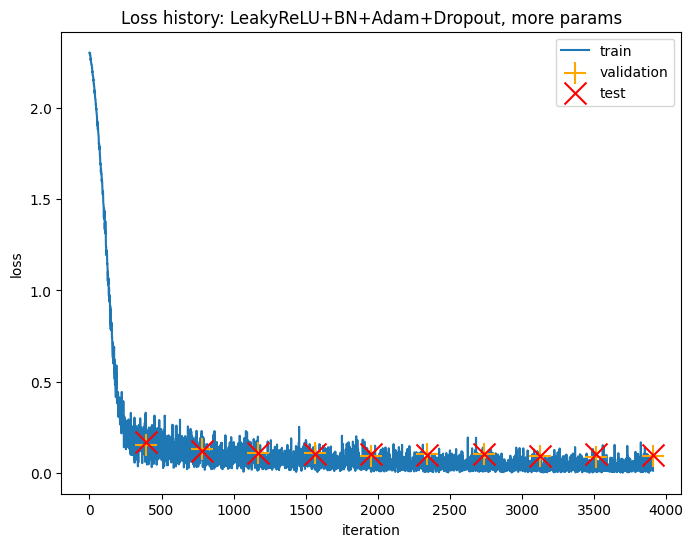

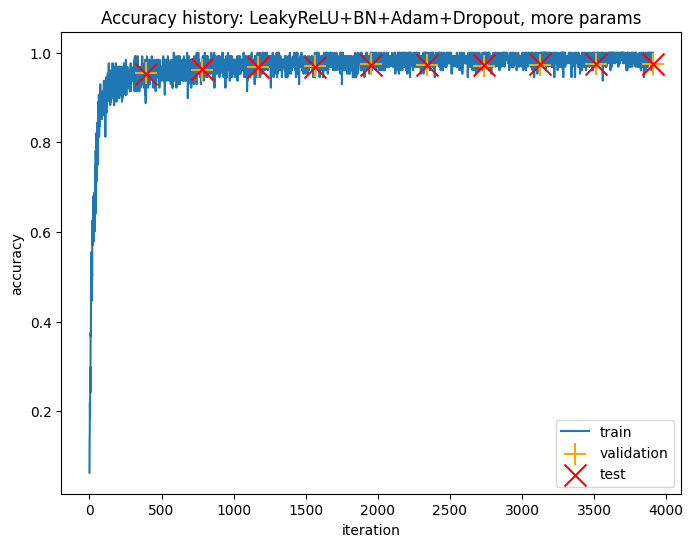

Validation accuracy: 0.973900
Test accuracy: 0.974500
CPU times: total: 8min 20s
Wall time: 2min 21s


In [37]:
%%time

net = Sequential()
net.add(Flatten())
net.add(Linear(784, 512))
net.add(LeakyReLU())
net.add(Dropout(0.2))
net.add(BatchNormalization(0.01))
net.add(ChannelwiseScaling(512))
net.add(Linear(512, 256))
net.add(LeakyReLU())
net.add(Dropout(0.2))
net.add(BatchNormalization(0.01))
net.add(ChannelwiseScaling(256))
net.add(Linear(256, 128))
net.add(LeakyReLU())
net.add(Dropout(0.2))
net.add(BatchNormalization(0.01))
net.add(ChannelwiseScaling(128))
net.add(Linear(128, 10))
net.add(LogSoftMax())

# Optimizer params
optimizer_config = {'learning_rate' : 1e-3, 'beta1': 0.99, 'beta2': 0.99, 'epsilon': 1e-12}
optimizer_state = {}

train_loss_dp_big, train_acc_dp_big, val_loss_dp_big, val_acc_dp_big, test_loss_dp_big, test_acc_dp_big =\
                    train(net, optimizer_config, optimizer_state, n_epoch=10, title='LeakyReLU+BN+Adam+Dropout, more params', opt='adam')

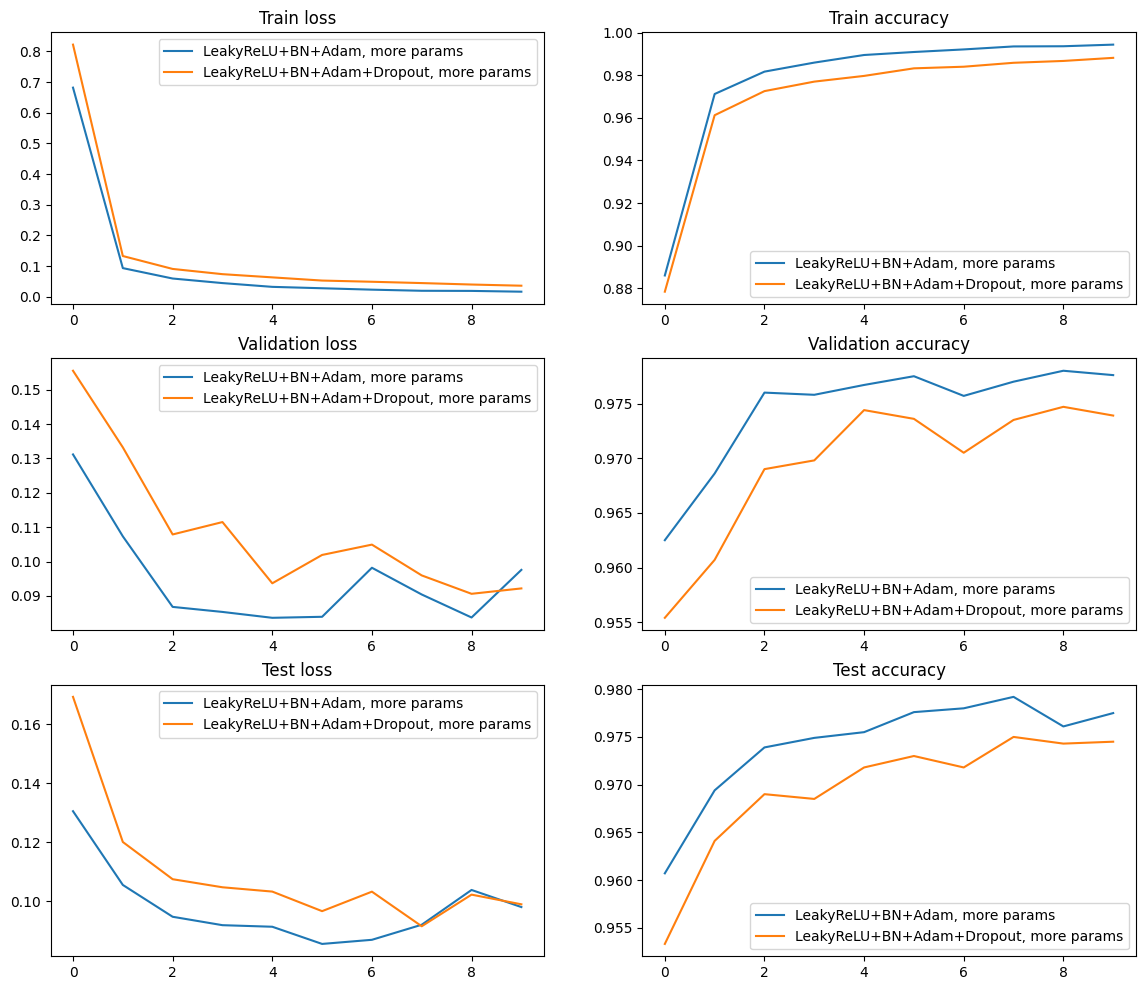

In [38]:
f, axes = plt.subplots(3, 2, figsize=(14, 12))

axes[0, 0].set_title('Train loss')
axes[0, 0].plot(train_loss_big, label='LeakyReLU+BN+Adam, more params')
axes[0, 0].plot(train_loss_dp_big, label='LeakyReLU+BN+Adam+Dropout, more params')
axes[0, 0].legend(loc='best')

axes[1, 0].set_title('Validation loss')
axes[1, 0].plot(val_loss_big, label='LeakyReLU+BN+Adam, more params')
axes[1, 0].plot(val_loss_dp_big, label='LeakyReLU+BN+Adam+Dropout, more params')
axes[1, 0].legend(loc='best')

axes[2, 0].set_title('Test loss')
axes[2, 0].plot(test_loss_big, label='LeakyReLU+BN+Adam, more params')
axes[2, 0].plot(test_loss_dp_big, label='LeakyReLU+BN+Adam+Dropout, more params')
axes[2, 0].legend(loc='best')

axes[0, 1].set_title('Train accuracy')
axes[0, 1].plot(train_acc_big, label='LeakyReLU+BN+Adam, more params')
axes[0, 1].plot(train_acc_dp_big, label='LeakyReLU+BN+Adam+Dropout, more params')
axes[0, 1].legend(loc='best')

axes[1, 1].set_title('Validation accuracy')
axes[1, 1].plot(val_acc_big, label='LeakyReLU+BN+Adam, more params')
axes[1, 1].plot(val_acc_dp_big, label='LeakyReLU+BN+Adam+Dropout, more params')
axes[1, 1].legend(loc='best')

axes[2, 1].set_title('Test accuracy')
axes[2, 1].plot(test_acc_big, label='LeakyReLU+BN+Adam, more params')
axes[2, 1].plot(test_acc_dp_big, label='LeakyReLU+BN+Adam+Dropout, more params')
axes[2, 1].legend(loc='best')

plt.show()

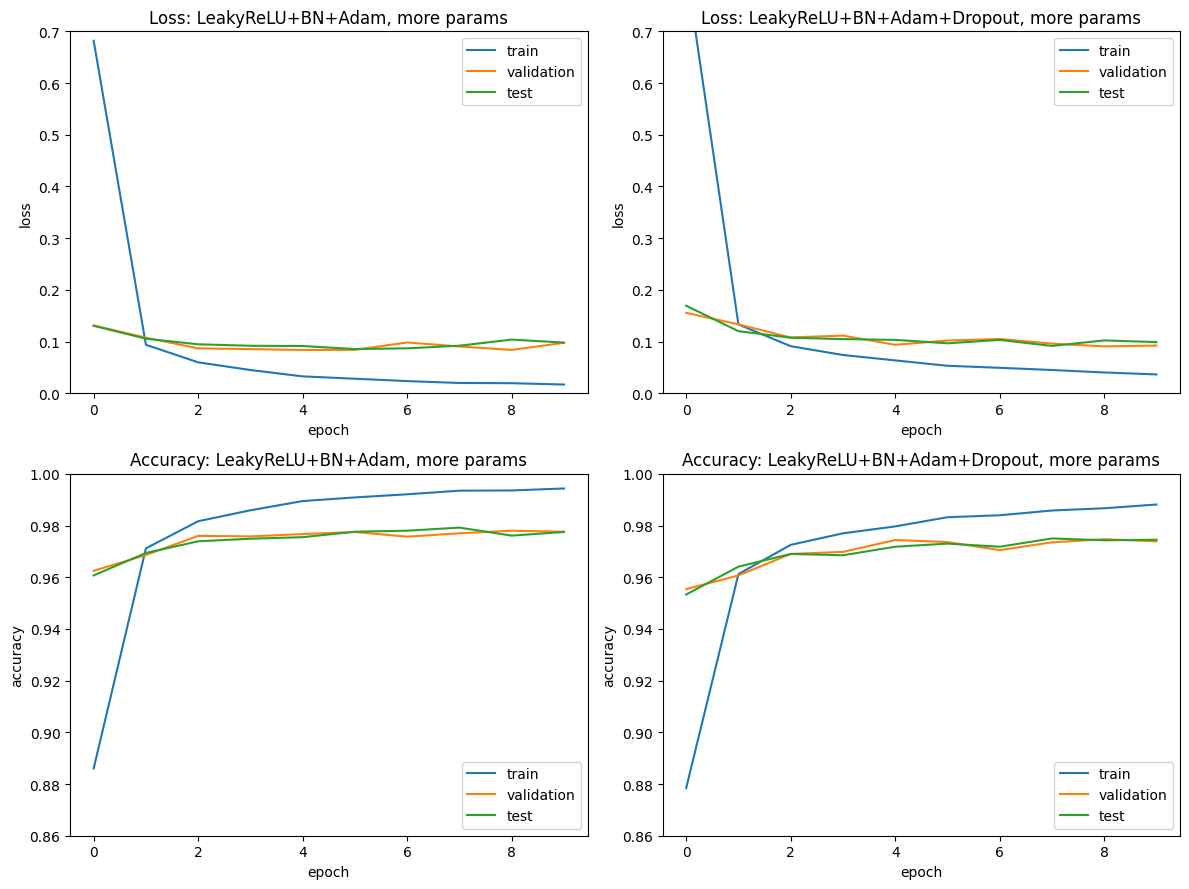

In [39]:
f, axes = plt.subplots(2, 2, figsize=(12, 9))

axes[0, 0].set_title('Loss: LeakyReLU+BN+Adam, more params')
axes[0, 0].plot(train_loss_big, label='train')
axes[0, 0].plot(val_loss_big, label='validation')
axes[0, 0].plot(test_loss_big, label='test')
axes[0, 0].legend(loc='best')
axes[0, 0].set_xlabel('epoch')
axes[0, 0].set_ylabel('loss')
axes[0, 0].set_ylim([0, 0.7])

axes[0, 1].set_title('Loss: LeakyReLU+BN+Adam+Dropout, more params')
axes[0, 1].plot(train_loss_dp_big, label='train')
axes[0, 1].plot(val_loss_dp_big, label='validation')
axes[0, 1].plot(test_loss_dp_big, label='test')
axes[0, 1].legend(loc='best')
axes[0, 1].set_xlabel('epoch')
axes[0, 1].set_ylabel('loss')
axes[0, 1].set_ylim([0, 0.7])

axes[1, 0].set_title('Accuracy: LeakyReLU+BN+Adam, more params')
axes[1, 0].plot(train_acc_big, label='train')
axes[1, 0].plot(val_acc_big, label='validation')
axes[1, 0].plot(test_acc_big, label='test')
axes[1, 0].legend(loc='best')
axes[1, 0].set_xlabel('epoch')
axes[1, 0].set_ylabel('accuracy')
axes[1, 0].set_ylim([0.86, 1])

axes[1, 1].set_title('Accuracy: LeakyReLU+BN+Adam+Dropout, more params')
axes[1, 1].plot(train_acc_dp_big, label='train')
axes[1, 1].plot(val_acc_dp_big, label='validation')
axes[1, 1].plot(test_acc_dp_big, label='test')
axes[1, 1].legend(loc='best')
axes[1, 1].set_xlabel('epoch')
axes[1, 1].set_ylabel('accuracy')
axes[1, 1].set_ylim([0.86, 1])

plt.tight_layout()
plt.show()

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# Архитектура сети
class CustomNet(nn.Module):
    def __init__(self):
        super(CustomNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 512)
        self.relu1 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.LeakyReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.relu3 = nn.LeakyReLU()
        self.dropout3 = nn.Dropout(0.2)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 10)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.bn1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.bn2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        x = self.bn3(x)
        x = self.fc4(x)
        x = self.log_softmax(x)
        return x

# Функция обучения
def train_model(model, optimizer, criterion, train_loader, val_loader, n_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    for epoch in range(n_epochs):
        model.train()
        train_loss, train_correct = 0, 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Если метки в формате one-hot, преобразуем их
            if y_batch.ndim > 1:
                y_batch = torch.argmax(y_batch, dim=1)

            # Forward
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Logging
            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == y_batch).sum().item()

        train_loss /= len(train_loader.dataset)
        train_accuracy = train_correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                if y_val.ndim > 1:
                    y_val = torch.argmax(y_val, dim=1)
                outputs = model(X_val)
                loss = criterion(outputs, y_val)
                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == y_val).sum().item()

        val_loss /= len(val_loader.dataset)
        val_accuracy = val_correct / len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{n_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Пример загрузки данных
# Преобразуем метки в индексы классов, если они в формате one-hot
y_train = np.argmax(y_train, axis=1) if y_train.ndim > 1 else y_train
y_val = np.argmax(y_val, axis=1) if y_val.ndim > 1 else y_val
y_test = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test

# Создание датасетов
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Инициализация модели, оптимизатора и функции потерь
model = CustomNet()
optimizer = optim.Adam(
    model.parameters(),
    lr=1e-3,
    betas=(0.99, 0.99),
    eps=1e-12
)
criterion = nn.NLLLoss()

# Обучение модели
train_model(model, optimizer, criterion, train_loader, val_loader, n_epochs=10)


Epoch 1/10
Train Loss: 0.0044, Train Accuracy: 0.9175
Val Loss: 0.0016, Val Accuracy: 0.9671
Epoch 2/10
Train Loss: 0.0022, Train Accuracy: 0.9577
Val Loss: 0.0013, Val Accuracy: 0.9755
Epoch 3/10
Train Loss: 0.0017, Train Accuracy: 0.9672
Val Loss: 0.0012, Val Accuracy: 0.9776
Epoch 4/10
Train Loss: 0.0014, Train Accuracy: 0.9723
Val Loss: 0.0012, Val Accuracy: 0.9770
Epoch 5/10
Train Loss: 0.0012, Train Accuracy: 0.9762
Val Loss: 0.0010, Val Accuracy: 0.9811
Epoch 6/10
Train Loss: 0.0011, Train Accuracy: 0.9780
Val Loss: 0.0011, Val Accuracy: 0.9799
Epoch 7/10
Train Loss: 0.0010, Train Accuracy: 0.9805
Val Loss: 0.0011, Val Accuracy: 0.9797
Epoch 8/10
Train Loss: 0.0009, Train Accuracy: 0.9827
Val Loss: 0.0010, Val Accuracy: 0.9832
Epoch 9/10
Train Loss: 0.0008, Train Accuracy: 0.9843
Val Loss: 0.0010, Val Accuracy: 0.9838
Epoch 10/10
Train Loss: 0.0007, Train Accuracy: 0.9854
Val Loss: 0.0010, Val Accuracy: 0.9826
